<a href="https://colab.research.google.com/github/PeraHive/project-redspot/blob/main/Simulations/Simulator.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Project Redspot

> By PeraHive

A robust IR vision-based localization framework for autonomous robotics

In [26]:
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import clear_output
import time


## Localizer

In [27]:

# --- 1. THE LOCALIZER CLASS ---
class IRLocalizer:
    def __init__(self, map_size, beacons, num_particles=500):
        self.map_size = map_size
        self.beacons = beacons
        self.num_particles = num_particles

        # Camera Defaults
        self.w, self.h = 480, 360
        self.focal_length = 400
        self.altitude = 100

        # Filter State
        self.particles = np.random.rand(num_particles, 2) * map_size
        self.weights = np.ones(num_particles) / num_particles

    def update_map_config(self, new_size=None, new_beacons=None):
        """Allows dynamic changing of the environment"""
        if new_size: self.map_size = new_size
        if new_beacons: self.beacons = new_beacons
        # Reset particles for the new map
        self.particles = np.random.rand(self.num_particles, 2) * self.map_size

    def config_camera(self, w, h, focal, altitude):
        """Sets the pinhole camera model parameters"""
        self.w, self.h = w, h
        self.focal_length = focal
        self.altitude = altitude

    def capture_blobs(self, true_pos):
        """Simulates raw sensor detection with noise"""
        blobs = []
        for b_pos in self.beacons.values():
            dx, dy = b_pos - true_pos
            px = (dx * self.focal_length / self.altitude) + (self.w / 2)
            py = (dy * self.focal_length / self.altitude) + (self.h / 2)

            if 0 <= px < self.w and 0 <= py < self.h:
                # Add 2-pixel sensor noise
                blobs.append(np.array([px, py]) + np.random.normal(0, 2, 2))
        return blobs

    def run_particle_filter(self, move_delta, observed_blobs):
        """The core estimation logic"""
        # 1. Predict (Motion Model)
        self.particles += move_delta + np.random.normal(0, 10, (self.num_particles, 2))
        self.particles = np.clip(self.particles, 0, self.map_size)

        # 2. Update (Measurement Model)
        if len(observed_blobs) > 0:
            for i, p_pos in enumerate(self.particles):
                likelihood = 0
                for b_pos in self.beacons.values():
                    dx, dy = b_pos - p_pos
                    px = (dx * self.focal_length / self.altitude) + (self.w / 2)
                    py = (dy * self.focal_length / self.altitude) + (self.h / 2)

                    if 0 <= px < self.w and 0 <= py < self.h:
                        for blob in observed_blobs:
                            dist = np.linalg.norm(np.array([px, py]) - blob)
                            likelihood += np.exp(-dist**2 / (2 * 20**2))
                self.weights[i] = likelihood + 1e-300

            self.weights /= np.sum(self.weights)

            # 3. Resample
            indices = np.random.choice(np.arange(self.num_particles),
                                       size=self.num_particles, p=self.weights)
            self.particles = self.particles[indices]
            self.weights = np.ones(self.num_particles) / self.num_particles

        return np.average(self.particles, weights=self.weights, axis=0)

## Simulator

In [47]:
class DroneSimulator:
    def __init__(self, localizer):
        self.localizer = localizer
        self.real_history = []
        self.est_history = []

    def generate_path(self, steps=100, type="lissajous"):
        """Creates mathematical flight paths"""
        t = np.linspace(0, 2 * np.pi, steps)
        mid = self.localizer.map_size / 2
        amp = (self.localizer.map_size / 2) - 300

        if type == "lissajous":
            x = mid + amp * np.cos(t)
            y = mid + amp * np.sin(2 * t)
        elif type == "circle":
            x = mid + amp * np.cos(t)
            y = mid + amp * np.sin(t)
        else: # Default straight line
            x = np.linspace(500, self.localizer.map_size - 500, steps)
            y = np.linspace(500, self.localizer.map_size - 500, steps)

        return np.stack((x, y), axis=-1)

    def run_simulation(self, steps=100, path_type="lissajous"):
        """Standard simulation without animation (High Speed)"""
        path = self.generate_path(steps, path_type)
        self.real_history = []
        self.est_history = []

        for i in range(steps):
            current_real = path[i]
            # Calculate movement delta from previous step
            delta = current_real - path[i-1] if i > 0 else np.array([0, 0])

            # Localizer workflow
            blobs = self.localizer.capture_blobs(current_real)
            estimated_pos = self.localizer.run_particle_filter(delta, blobs)

            self.real_history.append(current_real)
            self.est_history.append(estimated_pos)

        # Convert to numpy arrays to support [:, 0] slicing in plots
        self.real_history = np.array(self.real_history)
        self.est_history = np.array(self.est_history)
        print(f"Simulation complete: {steps} steps processed.")

    def animate_run(self, steps=100, path_type="lissajous"):
        """Simulation with live feedback (Slow - for visualization)"""
        path = self.generate_path(steps, path_type)
        self.real_history = []
        self.est_history = []

        for i in range(steps):
            current_real = path[i]
            delta = current_real - path[i-1] if i > 0 else np.array([0, 0])
            blobs = self.localizer.capture_blobs(current_real)
            estimated_pos = self.localizer.run_particle_filter(delta, blobs)

            self.real_history.append(current_real)
            self.est_history.append(estimated_pos)

            if i % 2 == 0:
                clear_output(wait=True)
                fig, (ax_cam, ax_map) = plt.subplots(1, 2, figsize=(15, 6))

                # Camera View
                ax_cam.set_facecolor('black')
                ax_cam.set_title("IR SENSOR VIEW")
                for b in blobs:
                    ax_cam.add_patch(plt.Circle((b[0], b[1]), 10, color='yellow'))
                ax_cam.set_xlim(0, self.localizer.w); ax_cam.set_ylim(self.localizer.h, 0)

                # Map View
                ax_map.set_title("LIVE PARTICLE FILTER")
                ax_map.scatter(self.localizer.particles[:,0], self.localizer.particles[:,1], c='cyan', s=1, alpha=0.5)
                for b_pos in self.localizer.beacons.values():
                    ax_map.scatter(b_pos[0], b_pos[1], c='red', marker='x')
                ax_map.plot(np.array(self.real_history)[:,0], np.array(self.real_history)[:,1], 'g-', alpha=0.3)
                ax_map.scatter(current_real[0], current_real[1], c='green', label='Real')
                ax_map.scatter(estimated_pos[0], estimated_pos[1], edgecolors='red', facecolors='none', s=100, label='Estimate')
                ax_map.set_xlim(0, self.localizer.map_size); ax_map.set_ylim(0, self.localizer.map_size)
                plt.show()

        self.real_history = np.array(self.real_history)
        self.est_history = np.array(self.est_history)

    def plot_results(self):
        """Standard X/Y tracking plots"""
        time_steps = np.arange(len(self.real_history))
        fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 8))

        ax1.plot(time_steps, self.real_history[:, 0], 'g-', label='Ground Truth X')
        ax1.plot(time_steps, self.est_history[:, 0], 'r--', label='PF Estimated X')
        ax1.set_title("X Tracking Accuracy"); ax1.legend(); ax1.grid(True)

        ax2.plot(time_steps, self.real_history[:, 1], 'b-', label='Ground Truth Y')
        ax2.plot(time_steps, self.est_history[:, 1], 'm--', label='PF Estimated Y')
        ax2.set_title("Y Tracking Accuracy"); ax2.legend(); ax2.grid(True)
        plt.tight_layout(); plt.show()

    def plot_map_view(self):
        """2D Top-down environment plot"""
        plt.figure(figsize=(8, 8))
        for b_id, b_pos in self.localizer.beacons.items():
            plt.scatter(b_pos[0], b_pos[1], c='red', marker='X', s=100)

        plt.plot(self.real_history[:, 0], self.real_history[:, 1], 'g-', label='Real Path', linewidth=2)
        plt.plot(self.est_history[:, 0], self.est_history[:, 1], 'r--', alpha=0.6, label='Estimated Path')
        plt.title("Full 2D Map View"); plt.legend(); plt.grid(True)
        plt.show()

## Execution

In [48]:
INITIAL_BEACONS = {
    "ID1": np.array([500, 500]),
    "ID2": np.array([2500, 500]),
    "ID3": np.array([1500, 1500]),
    "ID4": np.array([500, 2500]),
    "ID5": np.array([2500, 2500])
}

In [49]:
my_localizer = IRLocalizer(map_size=3000, beacons=INITIAL_BEACONS)
my_localizer.config_camera(w=480, h=360, focal=400, altitude=2000)

In [50]:
sim = DroneSimulator(my_localizer)

In [52]:
sim.run_simulation(steps=120, path_type="lissajous")


Simulation complete: 120 steps processed.


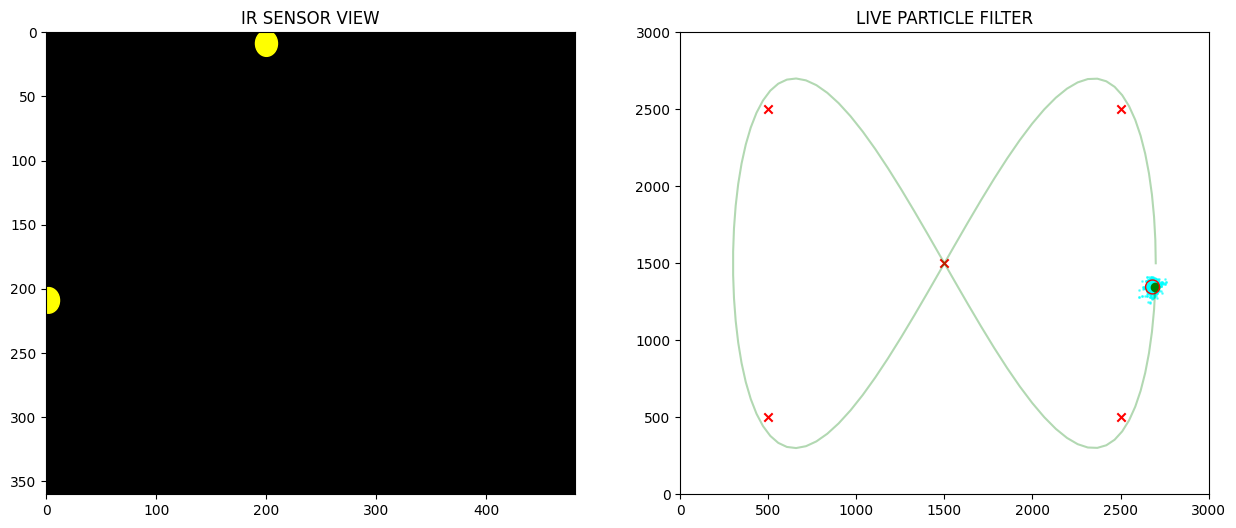

In [55]:
sim.animate_run(steps=100, path_type="lissajous")

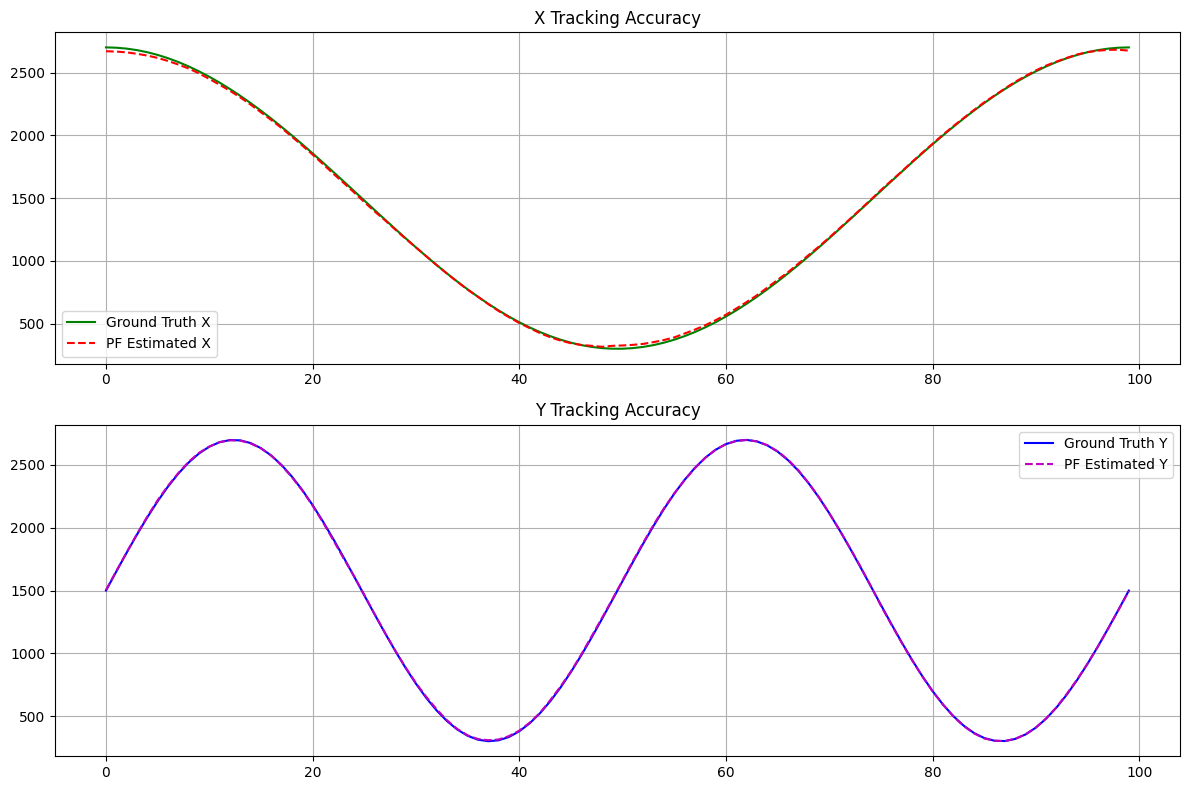

In [56]:
sim.plot_results()

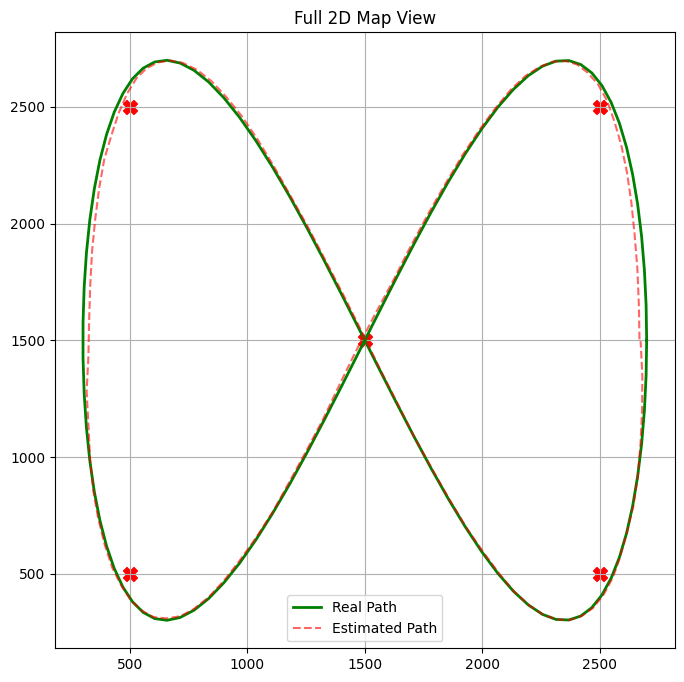

In [57]:
sim.plot_map_view()

## Basic Implementation

In [1]:
import numpy as np
import cv2
import matplotlib.pyplot as plt

In [2]:
MAP_SIZE = 3000
BEACON_MAP = {
    "B0": np.array([500.0, 500.0]),
    "B1": np.array([2500.0, 500.0]),
    "B2": np.array([1500.0, 1500.0]),
    "B3": np.array([500.0, 2500.0]),
    "B4": np.array([2500.0, 2500.0])
}

In [3]:
IMG_W, IMG_H = 480, 360
FOCAL_LENGTH = 400
ALTITUDE = 100

In [4]:
class ParticleFilter:
    def __init__(self, num_particles, map_size):
        self.num_particles = num_particles
        # Initialize particles randomly across the map
        self.particles = np.random.rand(num_particles, 2) * map_size
        self.weights = np.ones(num_particles) / num_particles

    def predict(self, move_step, std_dev=10):
        """Move particles based on drone movement + random noise"""
        self.particles += move_step + np.random.normal(0, std_dev, (self.num_particles, 2))
        # Keep particles within map bounds
        self.particles = np.clip(self.particles, 0, MAP_SIZE)

    def update(self, observed_blobs):
        """Re-weight particles based on how well they 'see' the beacons"""
        if len(observed_blobs) == 0:
            return # No info to update weights

        for i, p_pos in enumerate(self.particles):
            particle_likelihood = 0

            # For each particle, calculate where it WOULD see beacons
            for b_id, b_pos in BEACON_MAP.items():
                dx, dy = b_pos - p_pos
                px = (dx * FOCAL_LENGTH / ALTITUDE) + (IMG_W / 2)
                py = (dy * FOCAL_LENGTH / ALTITUDE) + (IMG_H / 2)

                # Check if this beacon should be in FOV for this particle
                if 0 <= px < IMG_W and 0 <= py < IMG_H:
                    # Compare to actual detected blobs in IR Matrix
                    for blob in observed_blobs:
                        dist = np.linalg.norm(np.array([px, py]) - blob)
                        # Gaussian likelihood: closer the better
                        particle_likelihood += np.exp(-dist**2 / (2 * 20**2))

            self.weights[i] = particle_likelihood + 1e-300 # Avoid zero

        self.weights /= np.sum(self.weights)

    def resample(self):
        """Focus particles in high-probability areas"""
        indices = np.random.choice(np.arange(self.num_particles),
                                   size=self.num_particles,
                                   p=self.weights)
        self.particles = self.particles[indices]
        self.weights = np.ones(self.num_particles) / self.num_particles

    def estimate(self):
        """Return the average position of all particles"""
        return np.average(self.particles, weights=self.weights, axis=0)

In [5]:
def get_flight_path(steps):
    """Generates a parametric flight path (Lissajous Curve)"""
    t = np.linspace(0, 2 * np.pi, steps)
    x = 1500 + 1000 * np.cos(t)
    y = 1500 + 1000 * np.sin(2 * t)
    return np.stack((x, y), axis=-1)

In [6]:
def capture_blobs(current_pos):
    """Simulates IR sensor and returns centroid coordinates of visible beacons"""
    blobs = []
    for b_pos in BEACON_MAP.values():
        dx, dy = b_pos - current_pos
        px = (dx * FOCAL_LENGTH / ALTITUDE) + (IMG_W / 2)
        py = (dy * FOCAL_LENGTH / ALTITUDE) + (IMG_H / 2)
        if 0 <= px < IMG_W and 0 <= py < IMG_H:
            # Add a bit of sensor noise to the detection
            blobs.append(np.array([px, py]) + np.random.normal(0, 2, 2))
    return blobs

In [7]:
num_steps = 100
real_path = get_flight_path(num_steps)
estimated_path = []

In [8]:
pf = ParticleFilter(num_particles=500, map_size=MAP_SIZE)

In [9]:
for i in range(num_steps):
    actual_pos = real_path[i]

    # Calculate movement since last step
    move_step = actual_pos - real_path[i-1] if i > 0 else np.array([0, 0])

    # 1. Predict
    pf.predict(move_step)

    # 2. Observe (Sensor Capture)
    blobs = capture_blobs(actual_pos)

    # 3. Update & Resample
    pf.update(blobs)
    pf.resample()

    # 4. Save Estimate
    estimated_path.append(pf.estimate())

estimated_path = np.array(estimated_path)

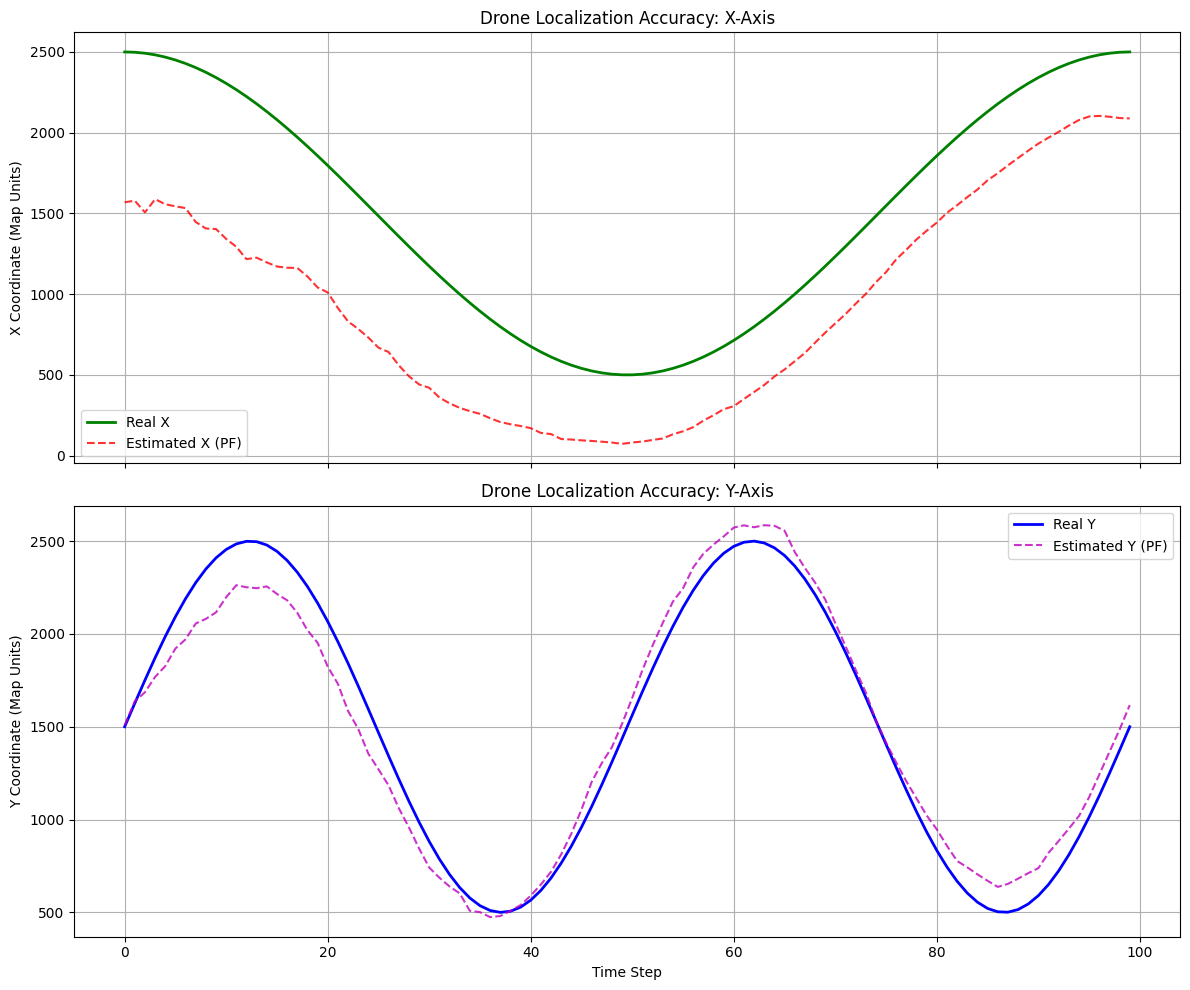

In [10]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 10), sharex=True)

# X-Coordinate Comparison
ax1.plot(real_path[:, 0], 'g-', label='Real X', linewidth=2)
ax1.plot(estimated_path[:, 0], 'r--', label='Estimated X (PF)', alpha=0.8)
ax1.set_ylabel("X Coordinate (Map Units)")
ax1.set_title("Drone Localization Accuracy: X-Axis")
ax1.legend()
ax1.grid(True)

# Y-Coordinate Comparison
ax2.plot(real_path[:, 1], 'b-', label='Real Y', linewidth=2)
ax2.plot(estimated_path[:, 1], 'm--', label='Estimated Y (PF)', alpha=0.8)
ax2.set_ylabel("Y Coordinate (Map Units)")
ax2.set_xlabel("Time Step")
ax2.set_title("Drone Localization Accuracy: Y-Axis")
ax2.legend()
ax2.grid(True)

plt.tight_layout()
plt.show()